In [ ]:
#https://towardsdatascience.com/nlp-performance-of-different-word-embeddings-on-text-classification-de648c6262b
#https://github.com/TomLin/Playground/blob/master/04-Model-Comparison-Word2vec-Doc2vec-TfIdfWeighted.ipynb

In [20]:
!pip install UtilTextClassification

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement UtilTextClassification (from versions: none)
ERROR: No matching distribution found for UtilTextClassification


In [2]:
import pandas as pd
import numpy as np
from numpy import random
import gensim
import spacy
import nltk
import os
import pickle

import matplotlib.pyplot as plt
import re
import warnings
import seaborn as sns
from gensim.models.doc2vec import TaggedDocument

warnings.simplefilter('ignore')
pd.set_option('max_colwidth',1000)


%matplotlib inline


def plot_freq(df, col, top_classes=20):
  
	"""
	:param df: dataframe
	:param col: list of label string
	:param top_classes: (integer) Plot top labels only.
	"""
	sns.set_style('whitegrid')

	col = col
	data = df[~df[col].isnull().any(axis=1)]
	data = data.set_index(col)

	# Check out the frequency over each concept.
	freq = pd.DataFrame({
			'freq': data.index.value_counts(normalize=True),
			'count': data.index.value_counts(normalize=False)},
			index=data.index.value_counts(normalize=True).index)
	print('Frequency(Top {})...'.format(top_classes))
	freq = freq[:top_classes]
	display(freq)

	# Plot bar chart.
	fig, ax = plt.subplots(1,1, figsize=(15,8))
	_ = freq.plot(y='freq', kind='bar', ax=ax, legend=False, colormap='Set2')
	_ = ax.set_ylabel('frequency', fontsize='x-large')
	_ = ax.set_xticklabels(freq.index.values, rotation=40, ha='right')
	_ = ax.set_title('Frequency over Each Class', fontsize='x-large')

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip gdrive/My\ Drive/nlp/complaints.csv.zip

Archive:  gdrive/My Drive/nlp/complaints.csv.zip
  inflating: complaints.csv          


In [5]:
df = pd.read_csv('complaints.csv')
df = df[pd.notnull(df['Consumer complaint narrative'])]
#df = df[pd.notnull(df['consumer_complaint_narrative'])]

In [10]:
df.shape

(949737, 18)

## Filtrando texto e rótulo

In [6]:
df = df[['Product','Consumer complaint narrative']]

In [7]:
# Experiment on smaller subset.
df = df[:25000]

In [17]:
display(df['Product'].value_counts())

Credit reporting, credit repair services, or other personal consumer reports    15417
Debt collection                                                                  3092
Credit card or prepaid card                                                      1912
Checking or savings account                                                      1646
Mortgage                                                                         1381
Money transfer, virtual currency, or money service                                604
Vehicle loan or lease                                                             423
Student loan                                                                      288
Payday loan, title loan, or personal loan                                         236
Consumer Loan                                                                       1
Name: Product, dtype: int64

Frequency(Top 30)...


,freq,count
"Credit reporting, credit repair services, or other personal consumer reports",0.61668,15417
Debt collection,0.12368,3092
Credit card or prepaid card,0.07648,1912
Checking or savings account,0.06584,1646
Mortgage,0.05524,1381
"Money transfer, virtual currency, or money service",0.02416,604
Vehicle loan or lease,0.01692,423
Student loan,0.01152,288
"Payday loan, title loan, or personal loan",0.00944,236
Consumer Loan,0.00004,1


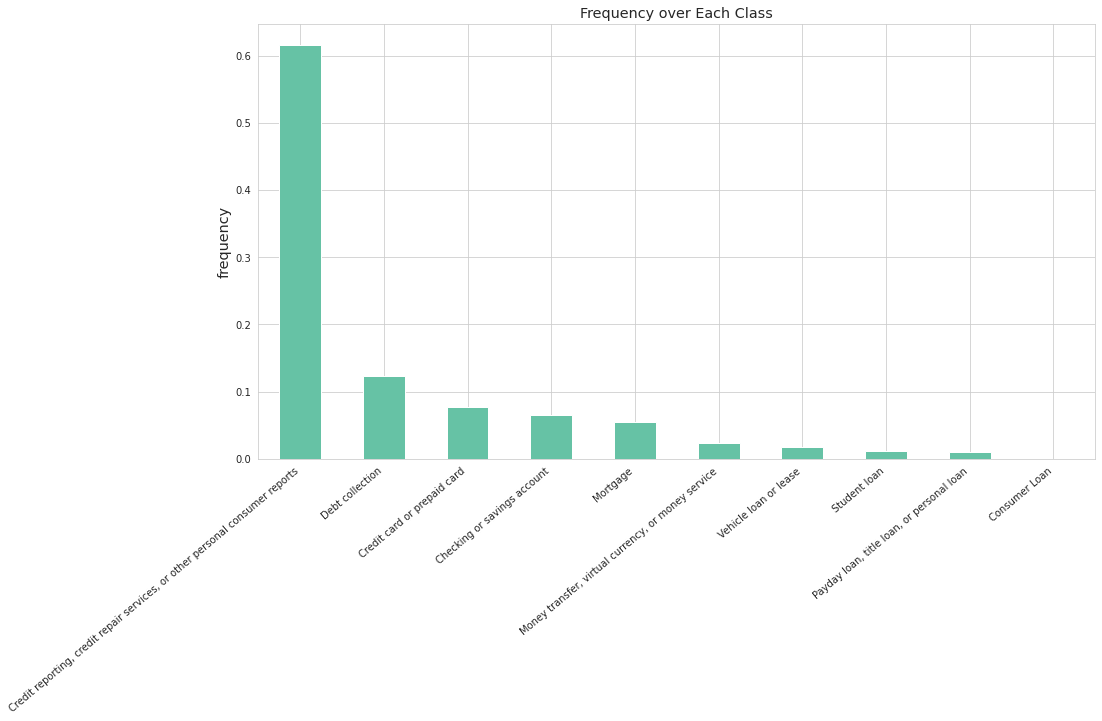

In [25]:
plot_freq(df, col=['Product'], top_classes=30)

# Pré-processamento de documentos

In [27]:
!python -m spacy download en_core_web_md 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96.4 MB 1.3 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051301 sha256=ad3b9472861def95a62ff55eefb9d9743794fa6e4b6102645ab883b8af4f5d2e
  Stored in directory: /tmp/pip-ephem-wheel-cache-igt3700n/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [1]:
import spacy


nlp = spacy.load('en_core_web_md')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [10]:
import gensim 

class DocPreprocess(object):

	def __init__(self,
				 nlp,
				 stop_words,
				 docs,
				 labels,
				 build_bi=False,
				 min_count=5,
				 threshold=10,
				 allowed_postags=['ADV', 'VERB', 'ADJ', 'NOUN', 'PROPN', 'NUM']):

		self.nlp = nlp  # spacy nlp object
		self.stop_words = stop_words  # spacy.lang.en.stop_words.STOP_WORDS
		self.docs = docs  # docs must be either list or numpy array or series of docs
		self.labels = labels # labels must be list or or numpy array or series of labels
		self.doc_ids = np.arange(len(docs))
		self.simple_doc_tokens = [gensim.utils.simple_preprocess(doc, deacc=True) for doc in self.docs]

		if build_bi:
			self.bi_detector = self.build_bi_detect(self.simple_doc_tokens, min_count=min_count, threshold=threshold)
			self.new_docs = self.make_bigram_doc(self.bi_detector, self.simple_doc_tokens)
		else:
			self.new_docs = self.make_simple_doc(self.simple_doc_tokens)
		self.doc_words = [self.lemmatize(doc, allowed_postags=allowed_postags) for doc in self.new_docs]
		self.tagdocs = [TaggedDocument(words=words, tags=[tag]) for words, tag in zip(self.doc_words, self.doc_ids)]


	def build_bi_detect(self, simple_doc_tokens, min_count, threshold):
		bi_ = gensim.models.phrases.Phrases(simple_doc_tokens, min_count=min_count, threshold=threshold)
		bi_detector = gensim.models.phrases.Phraser(bi_)  # wrapper enhance efficiency
		return bi_detector


	def make_bigram_doc(self, bi_detector, simple_doc_tokens):
		bi_doc_tokens = [bi_detector[doc_tokens] for doc_tokens in simple_doc_tokens]
		bi_docs = []
		for bi_tokens in bi_doc_tokens:
			bi_doc = " ".join(bi_tokens)  # concatenate back to a sentence
			bi_docs.append(bi_doc)
		return bi_docs


	def make_simple_doc(self, simple_doc_tokens):
		simple_docs = []
		for doc_tokens in simple_doc_tokens:
			simple = " ".join(doc_tokens)  # concatenate back to a sentence
			simple_docs.append(simple)
		return simple_docs


	def lemmatize(self, doc, allowed_postags):
		"""
		Lemmatize words and remove stop_words.
		:param doc: text
		:param allowed_postags: list of pos tags
		:return:
			list of tokens
		"""
		doc = self.nlp(doc)
		tokens = [token.lemma_ for token in doc if (
				token.pos_ in allowed_postags) and (token.text not in self.stop_words)]
		return tokens

In [11]:
all_docs = DocPreprocess(nlp, stop_words, df['Consumer complaint narrative'], df['Product'])

In [12]:
all_docs

In [15]:
os.getcwd()

'/content'

In [16]:
import pickle

dir_path = '/content'
# Save all_docs as pickle.
with open(os.path.join(dir_path, 'all_docs.pickle'), 'wb') as f:
    pickle.dump(all_docs, f, pickle.HIGHEST_PROTOCOL)

In [17]:
with open(os.path.join(dir_path, 'all_docs.pickle'), 'rb') as f:
    all_docs = pickle.load(f)

In [18]:
type(all_docs)

__main__.DocPreprocess

In [19]:
len(all_docs.tagdocs)

25000

In [20]:
print('Demo of doc words...')
all_docs.doc_words[4][:10]

Demo of doc words...


['receive', 'information', 'verify', 'debt']

In [21]:
print('Label of tagged document...')
all_docs.labels.iloc[4]

Label of tagged document...


'Debt collection'

# Construindo o modelo Word2vec

In [22]:
import multiprocessing
import sys
from gensim.models.word2vec import Word2Vec

workers = multiprocessing.cpu_count()
print('number of cpu: {}'.format(workers))
assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise."

number of cpu: 2


In [ ]:
word_model = Word2Vec(all_docs.doc_words,
                      min_count=2,
                      size=100,
                      window=5,
                      workers=workers,
                      iter=100)

# Calculando a média do word embedding para cada documento 